In [7]:
!pip3 install torch torchvision  # This will take a while installing.
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

## Lecture Notes: Basic Image Processing
Before jumping to build powerful and intelligent models for visual recognition it is always important to look at some pixels. Looking at images and pixels and transforming them in various ways gives us often valuable intuitions on how to find things about images, and how to build the algorithms behind intelligent visual recognition systems. 


### 1. Reading Images into Tensors.

We will be using pytorch's Tensors to manipulate images as tensors. In this section we will just read an RGB image (color image) and show it on Jupyter, then we will show each color channel independently.

Image size:  torch.Size([600, 600, 3])


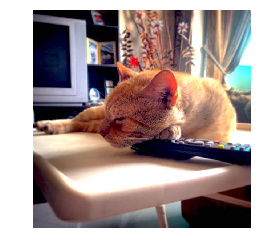

In [8]:
import torch, matplotlib
import numpy as np
import matplotlib.pyplot as plt
import imageio
matplotlib.rc('image', cmap = 'gray')

# Try maybe downloading the image in case the CS webserver goes down.
img_url = 'http://www.cs.virginia.edu/~vicente/deeplearning/cat-home.jpg'
img = imageio.imread(img_url)

# Transform into pytorch tensor.
img = torch.tensor(img, dtype=torch.float) / 255.0  

# Show the image size.
print('Image size: ', img.shape)

# Plot the image.
def display_image(img):
  plt.figure(); plt.imshow(img)
  plt.grid(False);  plt.axis('off'); plt.show()
  
display_image(img)

The img variable contains a torch.tensor of size height x width x channels corresponding to the dimensions of the image. Since this is a color image it contains Red, Green and Blue channels (RGB). Each entry is a floating-point number between 0 and 1. The code below slices each channel from the image and shows the separately (concatenated using torch.cat along the width dimension --- dimension 1).

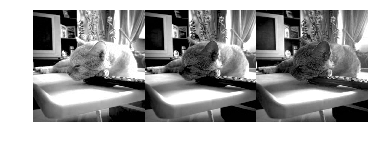

In [9]:
r_image = img[:, :, 0]
g_image = img[:, :, 1]
b_image = img[:, :, 2]

# for some reason matplotlib shows 1's as dark and 0's as light, 
# hence the need to do 1 - image.
display_image(torch.cat((r_image, g_image, b_image), 1))
# Also, please review what torch.cat does (nothing to do with felines).

### 2. Computing Image Statistics: Histograms
Histograms are useful because images can be of different sizes, but histograms can be computed to be of the same size regardless of image dimensions. Additionally we can normalize histograms so they sum to 1, or their  $\ell_2$ norm is 1 (euclidean norm, Frobenius norm in matrices).

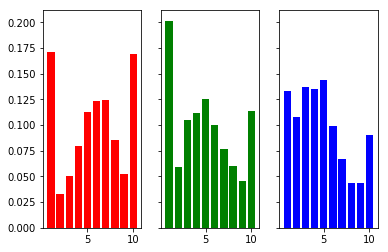

In [10]:
r_image = img[:, :, 0]
g_image = img[:, :, 1]
b_image = img[:, :, 2]

# Compute histograms for each channel.
hist_r = torch.histc(r_image, bins = 10, min = 0.0, max = 1.0)
hist_g = torch.histc(g_image, bins = 10, min = 0.0, max = 1.0)
hist_b = torch.histc(b_image, bins = 10, min = 0.0, max = 1.0)

# Normalize the histograms so that they sum to 1.
hist_r = hist_r.div(hist_r.sum())
hist_g = hist_g.div(hist_g.sum())
hist_b = hist_b.div(hist_b.sum())

# Plot the histograms.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True);
ax1.bar(np.linspace(1.0, 10.0, num = 10), hist_r.numpy(), color = 'r');
ax2.bar(np.linspace(1.0, 10.0, num = 10), hist_g.numpy(), color = 'g');
ax3.bar(np.linspace(1.0, 10.0, num = 10), hist_b.numpy(), color = 'b');

### 3. Manipulating Images Pixel by Pixel
In this section, we will apply pixel-wise operations on the image. A pixel is just the tuple of (red, green, blue) values for a corresponding location (row, column) in the image tensor. A simple operation is making the image brighter by scaling each pixel value in every location by a constant, since each pixel represents color intensity at each location

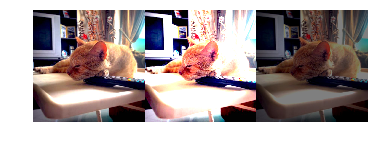

In [11]:
brighter_image = (2.1 * img).clamp_(0, 1)
darker_image = (0.5 * img)

display_image(torch.cat((img, brighter_image, darker_image), 1))

There are a couple of things you have to pay attention here: (1) we are using pytorch scalar-tensor operations, the multiplication of the scalar 2.1 affects every entry in the tensor img, and (2) we are using clamp_ which is an in-place operator (all operators with an underscore are in-place in pytorch), which is used to avoid overflowing the pixel values, or making the go beyond the valid range of values which is between 0 and 1.

### 4. Manipulating Images with Convolutions: Image Filtering

Let's assume a grayscale image (single channel). A convolution is a function that takes an input 2D image $I(x,y)$ and outputs a filtered imaged $I'(x,y)$ such that $I'(x, y) = f(\text{neighborhood of } I(x, y))$. This means that in order to compute the value of the output pixel $I'(x, y)$ we will need not only the input pixel value $I(x, y)$ (as we did for brightness) but also its neighboring pixel values. This is not a strict definition but this is the basic idea.

Most convolution operations we will be using during the course will use an $n\text{x}n$ number of neighboring pixels, and will be of the form:

$$I'(u,v) = \sum_{i=0}^{n-1}\sum_{j=0}^{n-1}{w_{i,j}I(u - \lfloor n / 2 \rfloor + i, v-\lfloor n / 2 \rfloor + j)} + b$$

For the purpose of this lab tutorial $b$ will be zero, so the only parameters of our convolution operations will be the size of our neighborhood region $n$ and the weights $w_{i,j}$. Moreover, for the first few examples here the neighborhod size will be $3\text{x}3$, thus we will be dealing with the following operation to compute the output pixels $I'(u, v)$.

\begin{equation}
\begin{split}
I'(u,v) =\quad  &w_{0,0}I(u - 1, v - 1)\quad  &+\quad &w_{0,1}I(u - 1, v)\quad &+\quad &w_{0,2}I(u - 1, v + 1) \quad+ \\
          &w_{1,0}I(u, v - 1)\quad  &+\quad &w_{1,1}I(u, v)\quad &+\quad &w_{1,2}I(u, v + 1) \quad+ \\
          &w_{2,0}I(u + 1, v - 1)\quad  &+\quad &w_{2,1}I(u + 1, v)\quad &+\quad &w_{2,2}I(u + 1, v + 1) \quad+
\end{split}
\end{equation}

We are effectively computing a sliding window as illustrated here:

<img width="560" src="http://www.cs.virginia.edu/~vicente/recognition/notebooks/animation.gif" />

In practice, there are various ways of making the convolution operations faster by realizing that some computations are shared by consecutive windows, or by sacrificing memory and expressing the convolution as a single matrix multiplication, GPU acceleration is also possible and fortunately all of these are already implemented in pytorch. Convolutions are essential to obtain information from images as well as to apply many common effects to images like blurring, sharpening, etc. In pytorch we can use F.conv2d function to an input image. Here we will run a convolution on a grayscale version of the image using a kernel of size 3x3 where all the entries are 1/9.

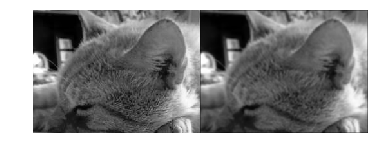

In [12]:
# The input is just a section of the red channel image.
# We will take the pixels between rows 150:340 and columns 160:420.
gray_img = (img[:, :, 0] + img[:, :, 1] + img[:, :, 2]) / 3.0
input_image = gray_img[150:340, 160:420]

# The kernel is a 3x3 matrix that computes the average around the pixel.
kv = 1.0 / 9.0
blur_weights = torch.Tensor([[kv, kv, kv],
                             [kv, kv, kv],
                             [kv, kv, kv]])

# Do not worry about the details of this implementation. 
# The reason for unsqueezes is because the F.conv2d function is very general, 
# and works for multiple images at a time, and multiple channels at a time, 
# and for multiple kernels at a time.
def SingleChannelConvolution(input_image, kernel):
    import torch.nn.functional as F
    kernel = kernel.contiguous()
    output = F.conv2d(input_image.unsqueeze(0).unsqueeze(0), 
                      kernel.unsqueeze(0).unsqueeze(0), padding = 1)
    return output.squeeze()


# Execute the convolution operation
output_image = SingleChannelConvolution(input_image, blur_weights)

display_image(torch.cat((input_image, output_image), 1))

The above results show the original image and the image after the convolution operator. It clearly shows that the image hs been blurred. One could blur the image using a larger kernel size than 3x3 or using different weights kv.

Now here are other filters that highlight vertical and horizontal edges in the input. These are also sometimes referred to as Sobel operators, and they are also finite differences that approximate the gradients of the image (This is the equivalent to taking a derivative of a function, except that here we have 2D functions in the discrete domain). We compute the sobel operator in the x-dimension and y-dimension. Each will highlight either vertical or horizontal edges, and the magnitude of these two gradients highlights all the edges.

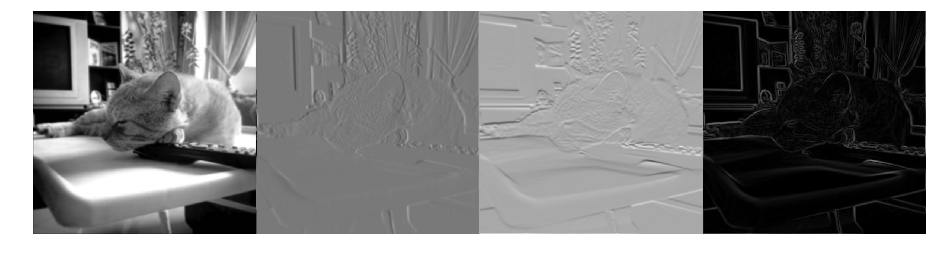

In [13]:
# The input is the grayscale channel image after a few rounds of blurring.
input_image = SingleChannelConvolution(gray_img, blur_weights)
input_image = SingleChannelConvolution(input_image, blur_weights.clone())
input_image = SingleChannelConvolution(input_image, blur_weights.clone())

# The kernel is a 3x3 matrix that computes the Sobel operator.
# See https://en.wikipedia.org/wiki/Sobel_operator
weights = torch.tensor([[1.0, 0.0, -1.0],
                        [2.0, 0.0, -2.0],
                        [1.0, 0.0, -1.0]])

# Execute the convolution operation for the weights and transposed weights.
gradx = SingleChannelConvolution(input_image, weights)
grady = SingleChannelConvolution(input_image, weights.t())

# Gradient magnitude  = sqrt(gradx.^2 + grady.^2)
magnitude = torch.sqrt(gradx * gradx + grady * grady)

# Make sure the images are still between 0 and 1.
gradx = (gradx - gradx.min()).div(gradx.max() - gradx.min())
grady = (grady - grady.min()).div(grady.max() - grady.min())
magnitude = magnitude / magnitude.max()

# Display the output.
plt.figure(figsize=(16,8)); 
plt.imshow(torch.cat((input_image, gradx, grady, magnitude), 1));
plt.grid(False);plt.axis('off'); plt.show()


We could also apply convolutions channel by channel and reconstruct the original image by merging the outputs for each convolution. We could also apply a different kernel to each channel. In fact the kernel matrix could also be an image itself. We will illustrate this below.

output torch.Size([593, 593, 3])
rgb_image torch.Size([600, 600, 3])


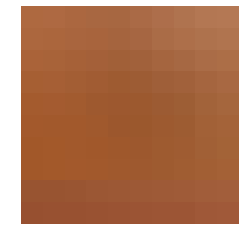

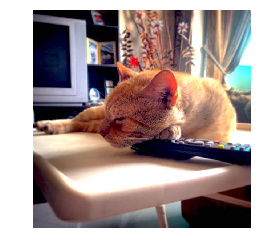

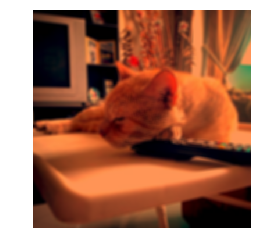

In [14]:
# Crop a patch from the image itself to use as convolutional filters.
rgb_image = img.clone()
kernel_patch = img[280:290, 160:170, :]

output1 = SingleChannelConvolution(rgb_image[:, :, 0], kernel_patch[:, :, 0])
output2 = SingleChannelConvolution(rgb_image[:, :, 1], kernel_patch[:, :, 1])
output3 = SingleChannelConvolution(rgb_image[:, :, 2], kernel_patch[:, :, 2])

# Add a dummy channel dimension to each output and concat across this dimension.
output_image = torch.cat((output1[:, :, np.newaxis], 
                          output2[:, :, np.newaxis],
                          output3[:, :, np.newaxis]), 2)

output_image = (output_image - output_image.min()) / \
               (output_image.max() - output_image.min())

print('output', output_image.size())
print('rgb_image', rgb_image.size())

display_image(kernel_patch)
display_image(rgb_image)
display_image(output_image)

Here is another example where we sample a different patch from the image to use as filter. As you can see, there is relationship between the apperance of the filter and the output image.

output torch.Size([593, 593, 3])
rgb_image torch.Size([600, 600, 3])


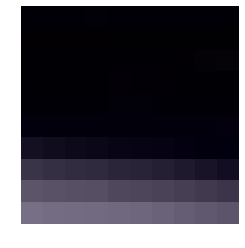

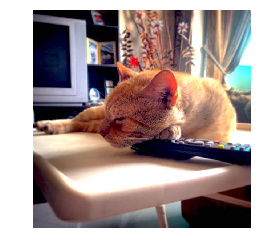

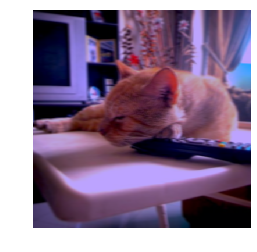

In [15]:
# Crop a patch from the image itself to use as convolutional filters.
rgb_image = img.clone()
kernel_patch = img[15:25, 100:110, :]

output1 = SingleChannelConvolution(rgb_image[:, :, 0], kernel_patch[:, :, 0])
output2 = SingleChannelConvolution(rgb_image[:, :, 1], kernel_patch[:, :, 1])
output3 = SingleChannelConvolution(rgb_image[:, :, 2], kernel_patch[:, :, 2])

# Add a dummy channel dimension to each output and concat across this dimension.
output_image = torch.cat((output1[:, :, np.newaxis], 
                          output2[:, :, np.newaxis],
                          output3[:, :, np.newaxis]), 2)

output_image = (output_image - output_image.min()) / \
               (output_image.max() - output_image.min())

print('output', output_image.size())
print('rgb_image', rgb_image.size())

display_image(kernel_patch)
display_image(rgb_image)
display_image(output_image)

output torch.Size([593, 543, 3])
rgb_image torch.Size([600, 600, 3])


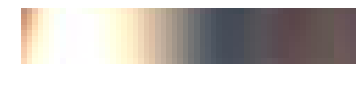

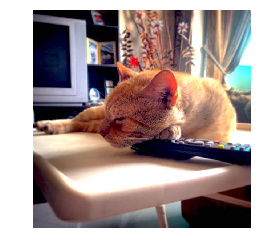

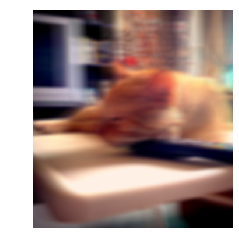

In [16]:
# Crop a patch from the image itself to use as convolutional filters.
rgb_image = img.clone()
kernel_patch = img[15:25, 440:500, :]

output1 = SingleChannelConvolution(rgb_image[:, :, 0], kernel_patch[:, :, 0])
output2 = SingleChannelConvolution(rgb_image[:, :, 1], kernel_patch[:, :, 1])
output3 = SingleChannelConvolution(rgb_image[:, :, 2], kernel_patch[:, :, 2])

# Add a dummy channel dimension to each output and concat across this dimension.
output_image = torch.cat((output1[:, :, np.newaxis], 
                          output2[:, :, np.newaxis],
                          output3[:, :, np.newaxis]), 2)

output_image = (output_image - output_image.min()) / \
               (output_image.max() - output_image.min())

print('output', output_image.size())
print('rgb_image', rgb_image.size())

display_image(kernel_patch)
display_image(rgb_image)
display_image(output_image)

**Lab assignment**

The purpose of this lab is to make sure you have the pytorch environment installed and running, or get started using Google Colaboratory, and familiarize yourself with some basic image processing routines. In addition to completing the above tutorial, here are the items you have to submit for grading. In all cases except the last time, please use the image of the cat provided in this assignment.

* **[2pts] ** In the tutorial we saw how to increase the overall brightness of an image or decrease the overall brightness. Here provide code to create a vignette effect. Similar to the Vignette effect included in instagram, where the center of the image has the original pixel intensities but the colors fade to dark as they get closer to the boundary of the image. **Important: ** Make sure to include the output of your code below (TAs will generally not run your code, your assignments will be graded based on the quality of your output). 


Original Image, Filter Applied to Image, Filter:


/home/brandon/Codes/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


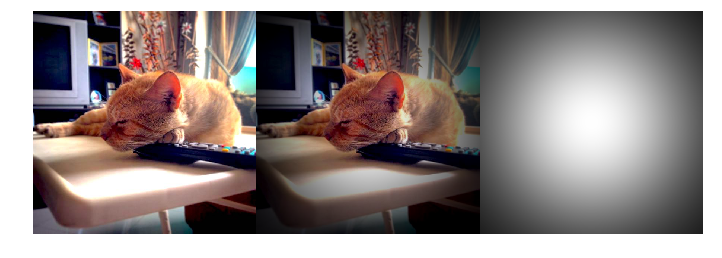

In [17]:
import math
# Your code goes here.
def gaussian_filter(x, y, mean, std):
    return math.exp(-1*((x-mean)**2 + (y-mean)**2)/(2*(std**2))) \
                            /(math.sqrt(6.28* (std**2)))
rgb_image = img.clone()
h, w = rgb_image.shape[0], rgb_image.shape[1]
mean = w//2
std = w *.34
norm_filter = [[[gaussian_filter(x,y,mean, std) for _ in range(3)] for x in range(w)] for y in range(h)]
norm_filter = torch.Tensor(norm_filter)
norm_filter /= torch.max(norm_filter)
output_image = rgb_image * norm_filter
# Output display code.
plt.figure(figsize = (12, 8))
print("Original Image, Filter Applied to Image, Filter:")
plt.imshow(torch.cat((rgb_image, output_image, norm_filter), 1))
plt.grid('off');  plt.axis('off'); plt.show()

* **[3pts] ** A common operation for an image is reducing the color palette. RGB images represent intensities from 0 to 255 for each channel, resulting in $16,777,216$ colors ($=256 \times 256 \times 256$). Re-map the colors to use only a total of 64 colors while trying to preserve the apperance of the image. Again, show the resulting image after restricting the total number of colors.

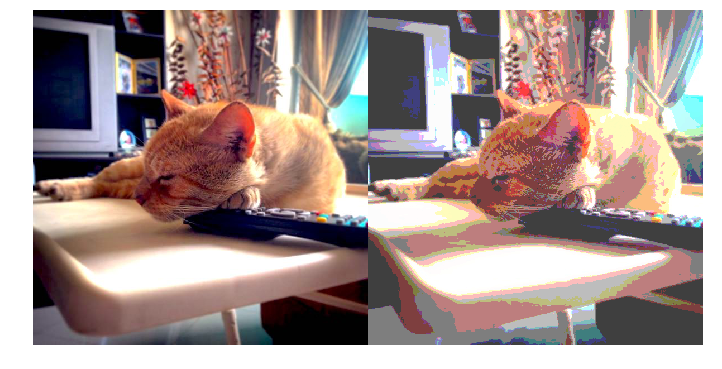

In [18]:
# Your code goes here.
# 4 red 4 green 4 blue
rgb_image = img.clone()
def map_pixel(pixel):
    mapping = 255
    for i in range(0,255,255//4):
        if(pixel*255 < i):
            mapping = i
            break
    return mapping/255.0
w = rgb_image.shape[1]
h = rgb_image.shape[0]
output_image = [[[map_pixel(rgb_image[i,j,k])for k in range(3)] for j in range(w)] for i in range(h)]
output_image = torch.Tensor(output_image)
# Output display code.
plt.figure(figsize = (12, 8))
plt.imshow(torch.cat((rgb_image, output_image), 1))
plt.grid('off');  plt.axis('off'); plt.show()

* **[2pts] ** In the last example of this tutorial, when we convolved the image with a patch. Why did the output_image (593 x 543 x 3) and the input rgb_image (600 x 600 x 3) have different width and height? Explain what is the precise relationship between the height of the input and output, and the width of the input and output.



* **[3pts]** Create your own filter: Convolve an image of your choosing with a filter that creates an interesting effect.


I chose to use a image of randomly colored tiles to see if I could:
1) Reshuffle the colors using a filter.
2) Highlight shapes in it.
3) Blend it.
The images below are images corresponding to original random, original shuffled, shape highlight in original, original blended



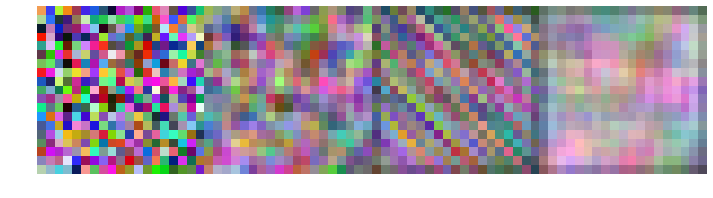


To reshuffle I apply a filter which combines pixels that do not include the ones immediately adjacent to the top left pixel being convoluted. This is so it looks more varied from the original.
I make a diagonally shaped filter which is easily seen below
The blended image just averages over all the pixels.



In [48]:
# Make sure you show here the filter and the input and output images (before and after filtering).

def apply_conv(img, filter_):
    output1 = SingleChannelConvolution(img[:,:,0], filter_)
    output2 = SingleChannelConvolution(img[:,:,1], filter_)
    output3 = SingleChannelConvolution(img[:,:,2], filter_)
    output_img = torch.cat((output1[:, :, np.newaxis], 
                          output2[:, :, np.newaxis],
                          output3[:, :, np.newaxis]),2)
    output_img /= torch.max(output_img)
    return output_img

w = 20
h = 20
img = torch.Tensor([[[np.random.randint(0,255)/255 for _ in range(3)] for _ in range(w)] for _ in range(h)])

#Design Filters
shuffle_filter = torch.Tensor([[0,0,0,0],
                               [0,2,2,0],
                               [0,2,2,0],
                               [0,0,0,0]])
shape_filter = torch.Tensor([[1,0,0,0],
                             [0,1,0,0],
                             [0,0,1,0],
                             [0,0,0,1]])
n = 4# n determines width/height of pixels to blend over
blend_filter = torch.Tensor([[1.0/n for _ in range(n)] for _ in range(n)])
shuffle_img = apply_conv(img, shuffle_filter)
shape_img = apply_conv(img, shape_filter)
blend_img = apply_conv(img, blend_filter)
img = img[1:,1:,:]
#output
print("""
I chose to use a image of randomly colored tiles to see if I could:
1) Reshuffle the colors using a filter.
2) Highlight shapes in it.
3) Blend it.
The images below are images corresponding to original random, original shuffled, shape highlight in original, original blended
""")
plt.figure(figsize = (12, 8))
plt.imshow(torch.cat((img,shuffle_img, shape_img, blend_img),1))
plt.grid('off');  plt.axis('off'); plt.show()

print("""
To reshuffle I apply a filter which combines pixels that do not include the ones immediately adjacent to the top left pixel being convoluted. This is so it looks more varied from the original.
I make a diagonally shaped filter which is easily seen below
The blended image just averages over all the pixels.
""")